# Machine Learning: Ridge Regression

Ridge regression is a regression technique that is quite similar to unadorned least squares linear regression: simply adding an $\ell_2$ **penalty** on the parameters $\beta$ to the objective function for linear regression yields the objective function for ridge regression.

Our goal is to find an assignment to $\beta$ that minimizes the function

$$f(\beta) = \|X\beta - Y\|_2^2 + \lambda \|\beta\|,$$

where $\lambda$ is a hyper-parameter and, as usual, $X$ is the training data and $Y$ the observations. In practice, we tune $\lambda$ until we find a model that generalizes well to the test data.

Ridge regression is an example of a **shrinkage method**: compared to least squares, it shrinks the parameter estimates in the hopes of **reducing variance, improving prediction accuracy, and aiding interpetation**.

In this notebook, we show how to fit a ridge regression model using CVXPY, how to evaluate the model, and how to tune the hyper-parameter $\lambda$.


In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

### Writing the objective function

We can decompose the **objective function** as the sum of a **least squares loss function** and an **$\ell_2$ regularizer**.

In [2]:
def loss_fn(X, Y, beta):
    return cp.pnorm(cp.matmul(X, beta) - Y, p=2)**2

def regularizer(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

### Generating data
Because ridge regression encourages the parameter estimates to be small, it is useful when, for example, the data matrix $X$ is **poorly conditioned**, i.e., when the product $X\beta$ is very sensitive to small perturbations in $\beta$. We therefore generate data that is somewhat poorly conditioned to use in our example.

In [3]:
def generate_data(m=1000, n=30, sigma=40):
    "Generates data matrix X and observations Y."
    beta_star = np.random.randn(n)
    # Generate an ill-conditioned data matrix
    X = np.random.randn(m, n)
    U, _, V = np.linalg.svd(X)
    s = np.linspace(30, 1, min(m, n))
    S = np.zeros((m, n))
    S[:min(m, n), :min(m, n)] = np.diag(s)
    X = np.dot(U, np.dot(S, V))
    # Corrupt the observations with additive Gaussian noise
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y

m = 1000
n = 30
sigma = 4

X, Y = generate_data(m, n, sigma)
X_train = X[:800, :]
Y_train = Y[:800]
X_test = X[800:, :]
Y_test = Y[800:]

### Fitting the model

All we need to do to fit the model is create a CVXPY problem where the objective is to minimize the the objective function defined above. We make $\lambda$ a CVXPY parameter, so that we can use a single CVXPY problem to obtain estimates for many values of $\lambda$.

In [4]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X, Y, beta, lambd)))

lambd_values = np.logspace(-2, 2, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

### Evaluating the model

Notice that, up to a point, penalizing the size of the parameters reduces test error at the cost of increasing the training error, trading off higher bias for lower variance; in other words, this indicates that, for our example, a properly tuned ridge regression **generalizes better** than a least squares linear regression.

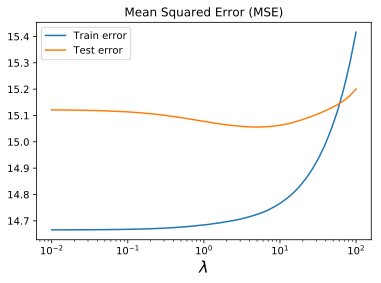

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
    
plot_train_test_errors(train_errors, test_errors, lambd_values)

### Regularization path
As expected, increasing $\lambda$ drives the parameters closer to $0$. In a real-world example, those parameters that approach zero slower than others might correspond to the more **informative** features. It is in this sense that ridge regression can be considered **model selection.**

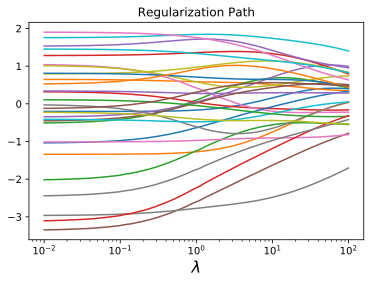

In [6]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()
    
plot_regularization_path(lambd_values, beta_values)